<a href="https://colab.research.google.com/github/ollie3951/ELE2038-Control-Lab/blob/main/ELE2038_Lab_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ELE2038 Inverted Pendulum Lab - Python Notebook

Oliver Ross, Lab Group 2, Last Updated: 02/04/2025

All code and figures available at https://github.com/ollie3951/ELE2038-Control-Lab

## Importing Libraries

In [60]:
!pip install control

import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import control as ctrl

## Inverted pendulum dynamical system

An inverted pendulum system can be represented by the diagram below.

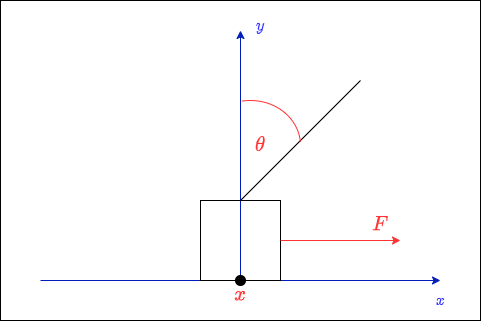

Let

$$x_1=x \quad \text{horizontal position (m)}$$
$$x_2=\dot{x} \quad \text{horizontal velocity (m/s)}$$
$$x_3=\theta \quad \text{angle of rod (rad)}$$
$$x_4=\dot{\theta} \quad \text{angular velocity (rad/s)},$$

we want to stabilise the system with the pendulum in the upright position, corresponding to the equilibrium point $$(F^{\text{eq}}, x_{3}^{\text{eq}}, x_{4}^{\text{eq}}) = (0, 0, 0).$$

From the textbook (Example 2.11 and Example 3.16), the dynamical system can be expressed in state space representation (SSR) as

$$\dot{x}_1=x_2$$
$$\dot{x}_2=\phi(F, x_3, x_4)=\frac{4mlx_4^2\sin{(x_3)}+4F-3mg\sin{(x_3)}\cos{(x_3)}}{4(M+m)-3m\cos^{2}{(x_3)}}$$
$$\dot{x}_3=x_4$$
$$\dot{x}_4=\psi(F, x_3, x_4)=\frac{- 3 F \cos{\left(x_{3} \right)} - 3 \ell m x_{4}^{2} \sin{\left(x_{3} \right)} \cos{\left(x_{3} \right)} + 3 g \left(M + m\right) \sin{\left(x_{3} \right)}}{\ell \left(4 M - 3 m \cos^{2}{\left(x_{3} \right)} + 4 m\right)},$$



where $g, M, m, \text{ and } l$ are constants describing the gravitational acceleration, mass of cart, mass of rod, and half length of rod respectively. Since the system of differential equations is in SSR, states are easily identified as $x_1, x_2, x_3, x_4$ and input $F$.

## Linearising the system

To make it easier to analyse the system, we linearise $\phi(F, x_3, x_4) \text{ and } \psi(F, x_3, x_4)$. Since we want to stabilise the system at $(F^{\text{eq}}, x_{3}^{\text{eq}}, x_{4}^{\text{eq}}) = (0, 0, 0)$, we apply the approximation about this point to give greatest accuracy.

In [61]:
def evaluate_at_equilibrium(f):
  "Evaluates a function of F, x3, and x4 at the equilibrium point (0, 0, 0)"
  return f.subs( [ (F, 0), (x3 ,0),  (x4, 0) ])

### $\psi(F, x_3, x_4)$

The linearisation of $\psi$ is
$$\psi(F, x_3, x_4) \approx \psi(0, 0, 0)
  + \left.\frac{\partial \psi}{\partial F}\right|_{0, 0, 0}F
  + \left.\frac{\partial \psi}{\partial x_3}\right|_{0, 0, 0}x_3
  +  \left.\frac{\partial \psi}{\partial x_4}\right|_{0, 0, 0}x_4$$

In [62]:
# symbolically defining all necessary variables
g, M, m, ell = sym.symbols('g, M, m, ell', positive=True)
F, x1, x2, x3, x4 = sym.symbols('F, x1, x2, x3, x4', real=True)
# symbolically defining psi
psi = - 3 * F * sym.cos(x3) - 3 * ell * m * x4**2 * sym.sin(x3) * sym.cos(x3) + 3 * g * (M + m) * sym.sin(x3)
psi /= ell * (4 * M - 3 * m * sym.cos(x3)**2 + 4 * m)
# evaluating psi(0, 0, 0)
psi0 = evaluate_at_equilibrium(psi)
# symbolically evaluating partial derivative of psi
d_psi_F = psi.diff(F)
d_psi_x3 = psi.diff(x3)
d_psi_x4 = psi.diff(x4)
# evaluating partial derivatives at (0, 0, 0)
d_psi_F_eq = evaluate_at_equilibrium(d_psi_F)
d_psi_x3_eq = evaluate_at_equilibrium(d_psi_x3)
d_psi_x4_eq = evaluate_at_equilibrium(d_psi_x4)
# symbolically defining linearised psi
psi_lin = psi0 + d_psi_F_eq * F + d_psi_x3_eq * x3 + d_psi_x4_eq * x4
# printing linearised psi
psi_lin

-3*F/(ell*(4*M + m)) + 3*g*x3*(M + m)/(ell*(4*M + m))

Therefore the linearisation is
$$\psi \approx - \underbrace{\frac{3}{\ell(4M + m)}}_{c}F + \underbrace{\frac{3g(M+m)}{\ell(4M+m)}}_d x_3$$
for $(F, x_3, x_4)$ close to $(0, 0, 0)$.
We can simply write
$$\dot{x}_4 = -cF + dx_3,$$
where $c$ and $d$ are positive constants.

### $\phi(F, x_3, x_4)$

The linearisation of $\phi$ is
$$\phi(F, x_3, x_4) \approx \phi(0, 0, 0)
  + \left.\frac{\partial \phi}{\partial F}\right|_{0, 0, 0}F
  + \left.\frac{\partial \phi}{\partial x_3}\right|_{0, 0, 0}x_3
  +  \left.\frac{\partial \phi}{\partial x_4}\right|_{0, 0, 0}x_4.$$

In [63]:
# symbolically defining phi
phi = (4 * m * ell * x4**2 * sym.sin(x3) + 4 * F - 3 * m * g * sym.sin(x3) * sym.cos(x3))
phi /= (4 * (M + m) - 3 * m * sym.cos(x3)**2)
# evaluating phi(0, 0, 0)
phi0 = evaluate_at_equilibrium(phi)
# symbolically evaluating partial derivative of phi
d_phi_F = phi.diff(F)
d_phi_x3 = phi.diff(x3)
d_phi_x4 = phi.diff(x4)
# evaluating partial derivatives at (0, 0, 0)
d_phi_F_eq = evaluate_at_equilibrium(d_phi_F)
d_phi_x3_eq = evaluate_at_equilibrium(d_phi_x3)
d_phi_x4_eq = evaluate_at_equilibrium(d_phi_x4)
# symbolically defining linearised phi
phi_lin = phi0 + d_phi_F_eq * F + d_phi_x3_eq * x3 + d_phi_x4_eq * x4
# printing linearised phi
phi_lin

4*F/(4*M + m) - 3*g*m*x3/(4*M + m)

Therefore the linearisation is
$$\phi \approx \underbrace{\frac{4}{4M+m}}_{e}F - \underbrace{\frac{3gm}{4M+m}}_f x_3$$
for $(F, x_3, x_4)$ close to $(0, 0, 0)$.
We can simply write
$$\dot{x}_2 = eF - fx_3,$$
where $e$ and $f$ are positive constants.

## Finding transfer functions

### $G_{\theta}(s)=\frac{X_3(s)}{F(s)}$

After linearising the system of differential equations, we have

$$\dot{x}_3=x_4,$$
$$\dot{x}_4=dx_3-cF.$$

Applying the Laplace transform, assuming zero initial conditions, to both equations gives

$$sX_3(s)=X_4(s) \quad \therefore \quad s^2X_3(s)=sX_4(s) ,$$
$$sX_4(s)=dX_3(s)-cF(s).$$

Substituting the second equation into the first, we get

$$s^2X_3(s)=dX_3(s)-cF(s),$$

which can be rearranged to give

$$G_\theta(s)=\frac{X_3(s)}{F(s)}=-\frac{c}{s^2-d}.$$

The poles of $G_\theta$ are $s=\pm\sqrt{d}$; we have a pole with a non-negative real part therefore the open-loop system for $\theta$ will not be BIBO stable. A controller will be required to stabilise this. The equations below show the open-loop system impulse, step, and frequency response for $θ$ before a controller is added, assuming actuator transfer function $G_a=1$ and sensor transfer function $G_s=1$.

In [64]:
# defining new symbols
c, d, t, omega = sym.symbols('c, d, t, omega', positive=True)
s = sym.symbols('s')
# symbolically defining transfer function for rod angle
Gtheta = -c / (s**2 - d)
# finding impulse response
F = 1
X3 = Gtheta * F
x3_impulse = sym.inverse_laplace_transform(X3, s, t)
# finding step response
F = 1 / s
X3 = Gtheta * F
x3_step = sym.inverse_laplace_transform(X3, s, t)
#finding frequency response
F = omega / (s**2+omega**2)
X3 = Gtheta * F
x3_freq = sym.inverse_laplace_transform(X3, s, t)

# printing impulse response
print('Impulse response:')
x3_impulse

Impulse response:


-c*sinh(sqrt(d)*t)/sqrt(d)

In [65]:
# printing step response
print('Step response:')
x3_step

Step response:


-c*(cosh(sqrt(d)*t)/d - 1/d)

In [66]:
# printing frequency response
print('Frequency response:')
x3_freq

Frequency response:


-c*omega*(-sin(omega*t)/(omega*(d + omega**2)) + sinh(sqrt(d)*t)/(sqrt(d)*(d + omega**2)))

Assuming $c=d=\omega=1$, these functions are plotted below using MATLAB to visually show the open-loop system is unstable.

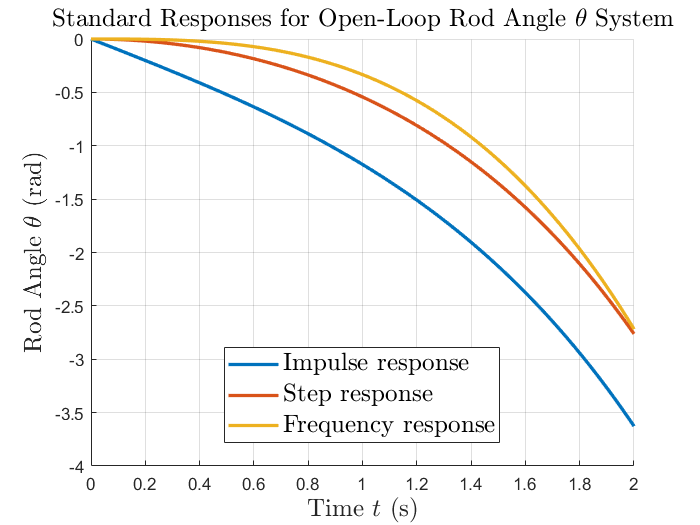

### $G_x(s)=\frac{X_1(s)}{F(s)}$

Assuming zero initial conditions, applying the Laplace transform to $\dot{x}_1=x_2$ and $\dot{x}_2=eF-fx_3$ gives

$$sX_1(s)=X_2(s) \quad \therefore \quad s^2X_1(s)=sX_2(s),$$
$$sX_2(s)=eF(s)-fX_3(s).$$

Substituting the second equation into the first, we get

$$s^2X_1(s)=eF(s)-fX_3(s),$$

then substituting $X_3(s)$ (derived in the previous section) into this equation and rearranging gives

$$G_x(s)=\frac{X_1(s)}{F(s)}=\frac{e(s^2-d)+cf}{s^2(s^2-d)}.$$

$G_x(s)$ has 2 poles at $s=0$, along with poles at $s=\pm\sqrt{d}$; we have poles with a non-negative real part therefore the open-loop system for $x$ will not be BIBO stable. Again, a controller will be required to stabilise this.

## 1. Designing a closed-loop control system to stabilise $\theta$

In the lab slides, it is given that $M = 0.3 {\rm kg}$, $m = 0.1{\rm kg}$, $\ell = 35{\rm cm}$, $g = 9.81 \tfrac{{\rm m}}{{\rm s}^2}$. From before, $c=\frac{3}{\ell(4M + m)}$ and $d=\frac{3g(M+m)}{\ell(4M+m)}$.

In [67]:
# defining s for use with transfer functions in control library
s = ctrl.TransferFunction.s
# defining constants given in assignment slides
M, m, ell, g = 0.3, 0.1, 0.35, 9.81
# defining constants c and d
denom = ell * (4*M + m)
c = 3 / denom
d = 3 * (M+m) * g /denom
# printing c and d
print(f"c = {c:.2f}, and d = {d:.2f}")

c = 6.59, and d = 25.87


To obtain zero offset ($G_\theta \text{ has no pole at } s=0$) and sufficient damping of oscillations, a PID controller will be used to control the system. The closed-loop block diagram is given below.

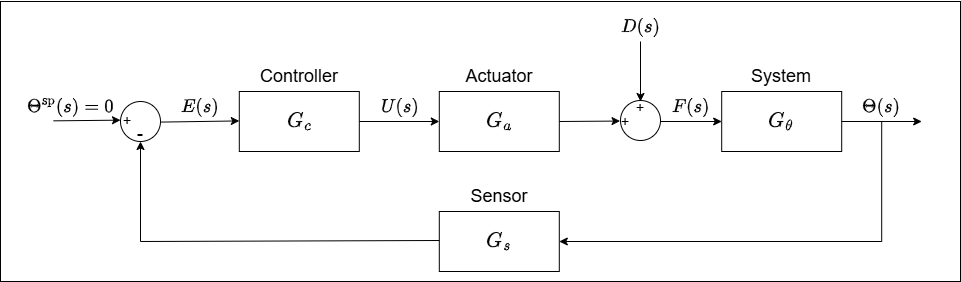

Since the set-point is zero, this block diagram may be simplified to represent the $D$ to $\Theta$ dynamics which is shown below.

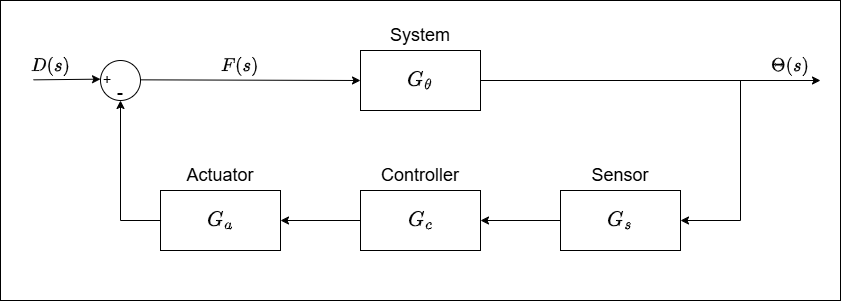

We want rod angle $\Theta$ to return to zero for any disturbance $D$.

The initial assumption is that the actuator and sensor transfer functions are both unity, $G_a=G_s=1$. The transfer function from $D$ to $\Theta$ is

$$G_{\text{load}}=\frac{\Theta(s)}{D(s)}=\frac{G_\theta}{1+G_sG_cG_aG_\theta}=\frac{G_\theta}{1+G_cG_\theta}$$

### Tuning the PID controller

In this section, we experiment with different PID controller parameter values. The graphs below shows the results of this experimentation.

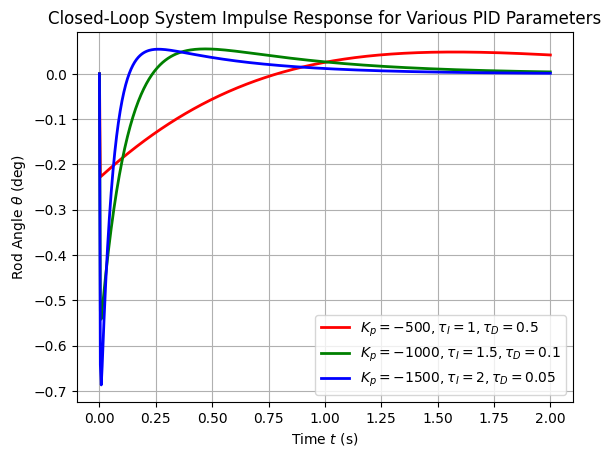

In [68]:
# defining times to evaluate response at
ts = np.linspace(0, 2, 500)
# defining Gtheta
Gtheta = -(c/(s**2-d))
# defining actuator and sensor transfer functions
Ga, Gs = 1, 1

# CONTROLLER 1
# Defining PID paramters
Kp = -500
taui = 1
taud = 0.5
# defining PID controller transfer function
Gc = Kp * (1 + taui/s + taud*s)
# defining the transfer function from D to Theta, Gload
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# calculating and plotting impulse response
t_imp, theta_imp = ctrl.impulse_response(Gload, ts)
plt.plot(t_imp, np.rad2deg(theta_imp), 'r', linewidth=2, label=r'$K_p=-500, \tau_I=1, \tau_D=0.5$')

# CONTROLLER 2
# Defining PID paramters
Kp = -1000
taui = 1.5
taud = 0.1
# defining PID controller transfer function
Gc = Kp * (1 + taui/s + taud*s)
# defining the transfer function from D to Theta, Gload
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# calculating and plotting impulse response
t_imp, theta_imp = ctrl.impulse_response(Gload, ts)
plt.plot(t_imp, np.rad2deg(theta_imp), 'g', linewidth=2, label=r'$K_p=-1000, \tau_I=1.5, \tau_D=0.1$')

# CONTROLLER 3
# Defining PID paramters
Kp = -1500
taui = 2
taud = 0.05
# defining PID controller transfer function
Gc = Kp * (1 + taui/s + taud*s)
# defining the transfer function from D to Theta, Gload
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# calculating and plotting impulse response
t_imp, theta_imp = ctrl.impulse_response(Gload, ts)
plt.plot(t_imp, np.rad2deg(theta_imp), 'b', linewidth=2, label=r'$K_p=-1500, \tau_I=2, \tau_D=0.05$')

# configuring plot
plt.xlabel(r'Time $t$ (s)')
plt.ylabel(r'Rod Angle $\theta$ (deg)')
plt.title('Closed-Loop System Impulse Response for Various PID Parameters')
plt.grid()
plt.legend()
plt.show()

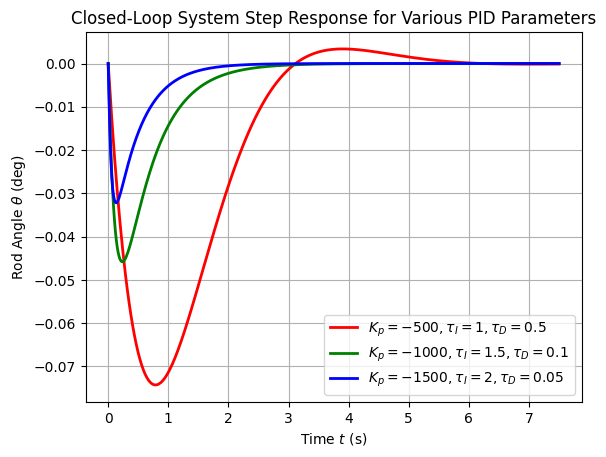

In [69]:
# defining times to evaluate response at
ts = np.linspace(0, 7.5, 500)

# CONTROLLER 1
# Defining PID paramters
Kp = -500
taui = 1
taud = 0.5
# defining PID controller transfer function
Gc = Kp * (1 + taui/s + taud*s)
# defining the transfer function from D to Theta, Gload
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# calculating and plotting step response
t_step, theta_step = ctrl.step_response(Gload, ts)
plt.plot(t_step, np.rad2deg(theta_step), 'r', linewidth=2, label=r'$K_p=-500, \tau_I=1, \tau_D=0.5$')

# CONTROLLER 2
# Defining PID paramters
Kp = -1000
taui = 1.5
taud = 0.1
# defining PID controller transfer function
Gc = Kp * (1 + taui/s + taud*s)
# defining the transfer function from D to Theta, Gload
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# calculating and plotting step response
t_step, theta_step = ctrl.step_response(Gload, ts)
plt.plot(t_step, np.rad2deg(theta_step), 'g', linewidth=2, label=r'$K_p=-1000, \tau_I=1.5, \tau_D=0.1$')

# CONTROLLER 3
# Defining PID paramters
Kp = -1500
taui = 2
taud = 0.05
# defining PID controller transfer function
Gc = Kp * (1 + taui/s + taud*s)
# defining the transfer function from D to Theta, Gload
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# calculating and plotting step response
t_step, theta_step = ctrl.step_response(Gload, ts)
plt.plot(t_step, np.rad2deg(theta_step), 'b', linewidth=2, label=r'$K_p=-1500, \tau_I=2, \tau_D=0.05$')

# configuring plot
plt.xlabel(r'Time $t$ (s)')
plt.ylabel(r'Rod Angle $\theta$ (deg)')
plt.title('Closed-Loop System Step Response for Various PID Parameters')
plt.grid()
plt.legend()
plt.show()

For the inverted pendulum controller, we aim to minimise overshoot and settling time, the blue trace represents the best controller for this system of the 3 plotted.

### Checking the force commanded by each controller when the disturbance is the unit impulse

We require the transfer function $G_F(s)=\frac{F(s)}{D(s)}=G_{\text{load}}G_sG_cG_a.$

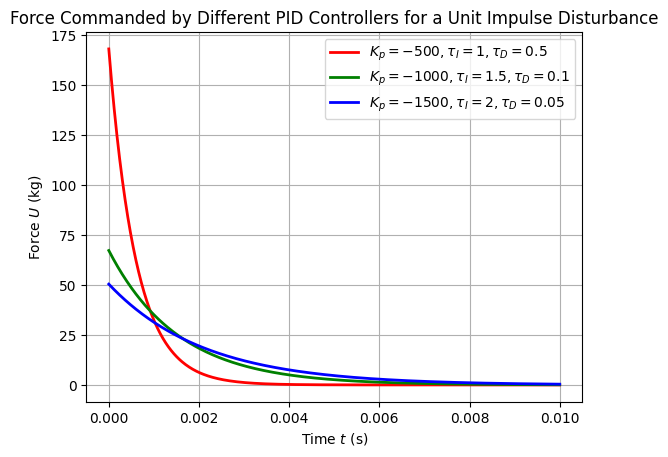

In [70]:
# defining times to evaluate response at
ts = np.linspace(0, 0.01, 500)

# CONTROLLER 1
# Defining PID paramters
Kp = -500
taui = 1
taud = 0.5
# defining PID controller transfer function
Gc = Kp * (1 + taui/s + taud*s)
# defining the transfer function from D to Theta, Gload
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# defining transfer function for force over input
GF = Gload * Gs * Ga * Gc
# calculating impulse response of the system with transfer function GF
t_imp, F_imp = ctrl.impulse_response(GF, ts)
# plotting
plt.plot(t_imp, F_imp / 9.81,  'r', linewidth=2, label=r'$K_p=-500, \tau_I=1, \tau_D=0.5$')

# CONTROLLER 2
# Defining PID paramters
Kp = -1000
taui = 1.5
taud = 0.1
# defining PID controller transfer function
Gc = Kp * (1 + taui/s + taud*s)
# defining the transfer function from D to Theta, Gload
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# defining transfer function for force over input
GF = Gload * Gs * Ga * Gc
# calculating impulse response of the system with transfer function GF
t_imp, F_imp = ctrl.impulse_response(GF, ts)
# plotting
plt.plot(t_imp, F_imp / 9.81, 'g', linewidth=2, label=r'$K_p=-1000, \tau_I=1.5, \tau_D=0.1$')

# CONTROLLER 3
# Defining PID paramters
Kp = -1500
taui = 2
taud = 0.05
# defining PID controller transfer function
Gc = Kp * (1 + taui/s + taud*s)
# defining the transfer function from D to Theta, Gload
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# defining transfer function for force over input
GF = Gload * Gs * Ga * Gc
# calculating impulse response of the system with transfer function GF
t_imp, F_imp = ctrl.impulse_response(GF, ts)
# plotting
plt.plot(t_imp, F_imp / 9.81, 'b', linewidth=2, label=r'$K_p=-1500, \tau_I=2, \tau_D=0.05$')

# configuring plot
plt.xlabel(r'Time $t$ (s)')
plt.ylabel(r'Force $U$ (kg)')
plt.title(r'Force Commanded by Different PID Controllers for a Unit Impulse Disturbance')
plt.grid()
plt.legend()
plt.show()

We avoid picking the controller represented by the red trace since the force commanded by the PID controller is too large. The controllers represented by the green and blue trace both offer a more reasonable required force which is not too oscillatory, as well as a short settling time and small overshoot for $\theta$ when the disturbance is a unit impulse or step. We will proceed with the blue trace due to its slightly shorter settling time and smaller force required.

### Plotting closed-loop system responses

In [71]:
# Defining PID parameters
Kp = -1500
taui = 2
taud = 0.05
# defining PID controller transfer function
Gc = Kp * (1 + taui/s + taud*s)
# defining the transfer function from D to Theta, Gload
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))

Plotting the response of the rod angle $\theta$ to standard disturbances (unit impulse and step) when the chosen controller is used

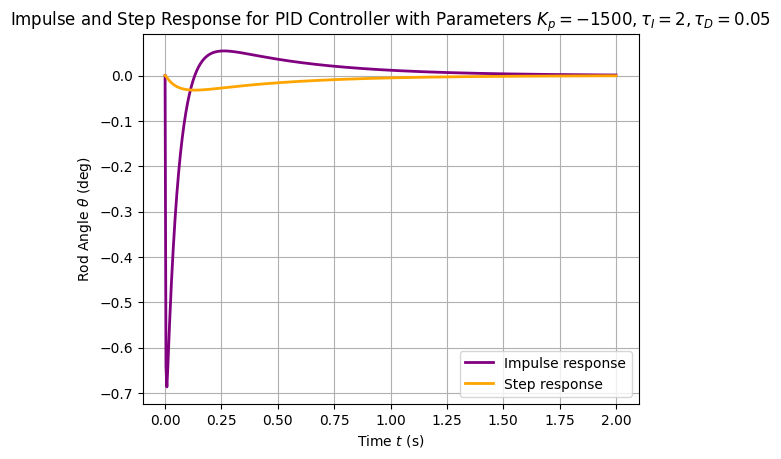

In [72]:
# defining times to evaluate response at
ts = np.linspace(0, 2, 500)
# calculating the system response when disturbance is unit impulse
t_imp, theta_imp = ctrl.impulse_response(Gload, ts)
# calculating the step response
t_step, theta_step = ctrl.step_response(Gload, ts)
# plotting the impulse response
plt.plot(t_imp, np.rad2deg(theta_imp), 'purple', linewidth=2, label='Impulse response')
# plotting the step response
plt.plot(t_step, np.rad2deg(theta_step), 'orange', linewidth=2, label='Step response')

# configuring plot
plt.xlabel(r'Time $t$ (s)')
plt.ylabel(r'Rod Angle $\theta$ (deg)')
plt.title(r'Impulse and Step Response for PID Controller with Parameters $K_p=-1500, \tau_I=2, \tau_D=0.05$')
plt.grid()
plt.legend()
plt.show()

The poles of the closed-loop system $G_{\text{load}}$ containing the chosen controller are given below:

In [73]:
# evaluating the poles of the closed loop system
poles = ctrl.poles(Gload)
# printing the poles
print(f"Closed-loop system poles: ")
for p in poles:
    print(f"{p.real:.2f} {'+ ' if p.imag >= 0 else '- '}{abs(p.imag):.2f}j")

Closed-loop system poles: 
-473.77 + 0.00j
-18.47 + 0.00j
-2.26 + 0.00j


All poles of the closed-loop system transfer function $G_{\text{load}}$ have negative real parts, therefore the closed-loop system controlled using a PID controller with parameters $K_p=-1500, \tau_I=2, \tau_D=0.05$ is BIBO stable.

### Proving zero offset of the chosen closed-loop system

The offset of the system can be calculated using the following equation,

$$\text{offset}=\theta^{\text{sp}}(t)-\lim_{t \to \infty}\theta(t).$$

For the inverted pendulum system $\theta^{\text{sp}}(t)=0$. The equation for offset can therefore be simplified to

$$\text{offset}=-\lim_{t \to \infty}\theta(t).$$

The final value theorem can be applied if $\Theta(s)$ has poles with only negative real parts with the exception of at most a single pole at the origin; this gives the equation

$$\lim_{s \to 0^{+}}s\Theta(s)=\lim_{t \to \infty}\theta(t).$$

Because $G_{\text{load}}=\Theta/D$, we know that $\Theta=G_{\text{load}}D$. $\Theta$ therefore shares all poles of $G_{\text{load}}$ and $D$; from the previous section we know that all poles of $G_{\text{load}}$ have negative real parts, and since we focus on offset for a unit impulse ($D(s)=1$) and unit step ($D(s)=1/s$) disturbance, D has no poles and one pole at $s=0$ respectively. This means that for these disturbances, $\Theta$ has at most one pole at the orgin, with all other poles having negative real parts and therefore the final value theorem may be applied.

#### $D(s)=1$

$$\theta(\infty)=\lim_{s \to 0^+}s\Theta(s)=\lim_{s \to 0^+}sG_{\text{load}}(s)D(s)=\lim_{s \to 0^+}sG_{\text{load}}(s).$$

In [74]:
s * Gload

TransferFunction(array([-6.59340659,  0.        ,  0.        ]), array([1.00000000e+00, 4.94505495e+02, 9.86423736e+03, 1.97802198e+04]))

$s$ is present in the numerator, therefore $\theta(\infty)=0$ so

$$\text{offset}=-\lim_{t \to \infty}\theta(t)=0.$$

The offset is zero when the disturbance is a unit impulse.

#### $D(s) = 1 / s$

$$\theta(\infty)=\lim_{s \to 0^+}s\Theta(s)=\lim_{s \to 0^+}sG_{\text{load}}(s)D(s)=\lim_{s \to 0^+}G_{\text{load}}(s).$$

In [75]:
Gload

TransferFunction(array([-6.59340659,  0.        ]), array([1.00000000e+00, 4.94505495e+02, 9.86423736e+03, 1.97802198e+04]))

$s$ is present in the numerator, therefore $\theta(\infty)=0$ so

$$\text{offset}=-\lim_{t \to \infty}\theta(t)=0.$$

The offset is zero when the disturbance is a unit step.

### Brief discussion of results

Using a PID controller, the rod angle $\theta$ of an inverted pendulum system can be stabilised at a set point of 0 degrees. From the plots given in the controller tuning section, it can be seen that the controller which is most effective at controlling $\theta$ has a very large, negative $K_p$ value. Furthermore, it can be seen that for the 3 controllers plotted, increasing $\tau_I$ and decreasing $\tau_{D}$ creates a more desirable closed-loop system response to disturbances in terms of minimising oscillatory behaviour and settling time. The controller proposed is BIBO stable, has zero offset and settles in less than 1.5 seconds for impulse and step disturbances, and requires a reasonably small and non-oscillatory force from the actuator.

## 2. Studying effect of first-order actuator on closed-loop system

In this section, instead of assuming the actuator has a tranfer function of unity we will assume it has the form of a first order system,

$$G_a=\frac{K_a}{\tau_a s + 1},$$

where $K_a=1$ and $\tau_a$ is the time constant which will be varied to investigate its effect on the closed-loop system.

Since the unit impulse and step most closely resemble typical disturbances which this system is likely to practically experience, we will plot how varying the actuator time constant affects the impulse and step response of the closed-loop system.

### Closed-loop system response for various small values of $\tau_a$ referenced to $\tau_a=0$

#### Impulse response

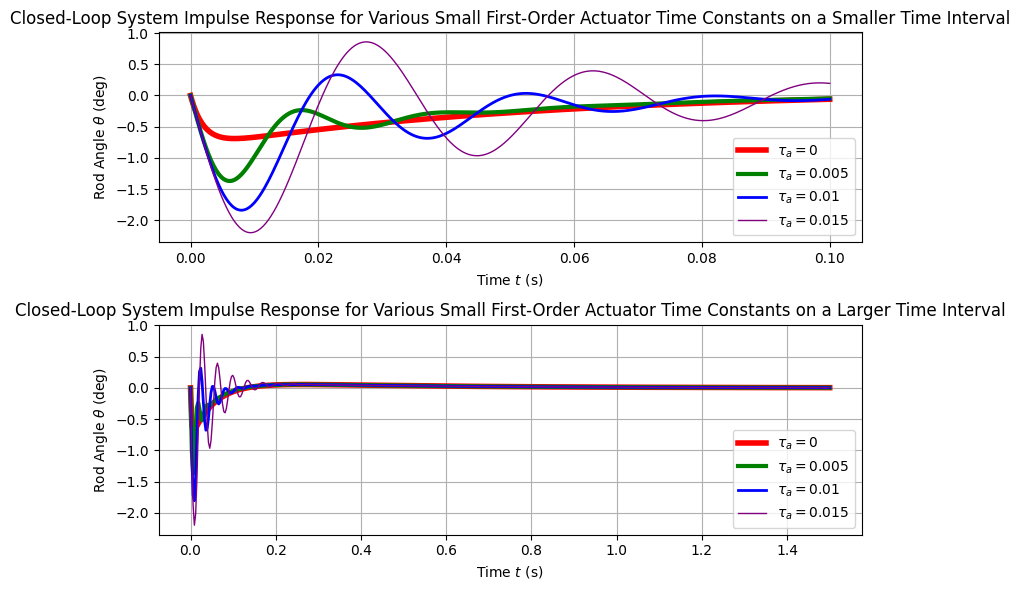

In [76]:
# defining times to find impulse response at
ts1 = np.linspace(0, 0.1, 500) # small time plot
ts2 = np.linspace(0, 1.5, 500) # large time plot

# Create a figure and a set of subplots to show small and large time interval
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.set_title('Closed-Loop System Impulse Response for Various Small First-Order Actuator Time Constants on a Smaller Time Interval')
ax2.set_title('Closed-Loop System Impulse Response for Various Small First-Order Actuator Time Constants on a Larger Time Interval')

# ACTUATOR 1 - unchanged from prior section since time constant is taken as zero
# redefining Ga
Ka = 1 # fixed
taua = 0 # will be varied
Ga = Ka / (taua * s + 1)
# redefining the closed-loop (Theta over D) system containing the new actuator
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# calculating and plotting impulse response for small time
t_imp, theta_imp = ctrl.impulse_response(Gload, ts1)
ax1.plot(t_imp, np.rad2deg(theta_imp), 'r', linewidth=4, label=r'$\tau_a=0$')
# calculating and plotting impulse response for large time
t_imp, theta_imp = ctrl.impulse_response(Gload, ts2)
ax2.plot(t_imp, np.rad2deg(theta_imp), 'r', linewidth=4, label=r'$\tau_a=0$')

# ACTUATOR 2 - introducing very small time constant
# redefining Ga
Ka = 1 # fixed
taua = 0.005 # will be varied
Ga = Ka / (taua * s + 1)
# redefining the closed-loop (Theta over D) system containing the new actuator
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# calculating and plotting impulse response
t_imp, theta_imp = ctrl.impulse_response(Gload, ts1)
ax1.plot(t_imp, np.rad2deg(theta_imp), 'g', linewidth=3, label=r'$\tau_a=0.005$')
# calculating and plotting impulse response for large time
t_imp, theta_imp = ctrl.impulse_response(Gload, ts2)
ax2.plot(t_imp, np.rad2deg(theta_imp), 'g', linewidth=3, label=r'$\tau_a=0.005$')

# ACTUATOR 3
# redefining Ga
Ka = 1 # fixed
taua = 0.01 # will be varied
Ga = Ka / (taua * s + 1)
# redefining the closed-loop (Theta over D) system containing the new actuator
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# calculating and plotting impulse response
t_imp, theta_imp = ctrl.impulse_response(Gload, ts1)
ax1.plot(t_imp, np.rad2deg(theta_imp), 'b', linewidth=2, label=r'$\tau_a=0.01$')
# calculating and plotting impulse response for large time
t_imp, theta_imp = ctrl.impulse_response(Gload, ts2)
ax2.plot(t_imp, np.rad2deg(theta_imp), 'b', linewidth=2, label=r'$\tau_a=0.01$')

# ACTUATOR 4
# redefining Ga
Ka = 1 # fixed
taua = 0.015 # will be varied
Ga = Ka / (taua * s + 1)
# redefining the closed-loop (Theta over D) system containing the new actuator
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# calculating and plotting impulse response
t_imp, theta_imp = ctrl.impulse_response(Gload, ts1)
ax1.plot(t_imp, np.rad2deg(theta_imp), 'purple', linewidth=1, label=r'$\tau_a=0.015$')
# calculating and plotting impulse response for large time
t_imp, theta_imp = ctrl.impulse_response(Gload, ts2)
ax2.plot(t_imp, np.rad2deg(theta_imp), 'purple', linewidth=1, label=r'$\tau_a=0.015$')

# configuring plot
ax1.set_ylabel(r'Rod Angle $\theta$ (deg)')
ax1.set_xlabel(r'Time $t$ (s)')
ax2.set_ylabel(r'Rod Angle $\theta$ (deg)')
ax2.set_xlabel(r'Time $t$ (s)')
ax1.grid()
ax2.grid()
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()

#### Step response

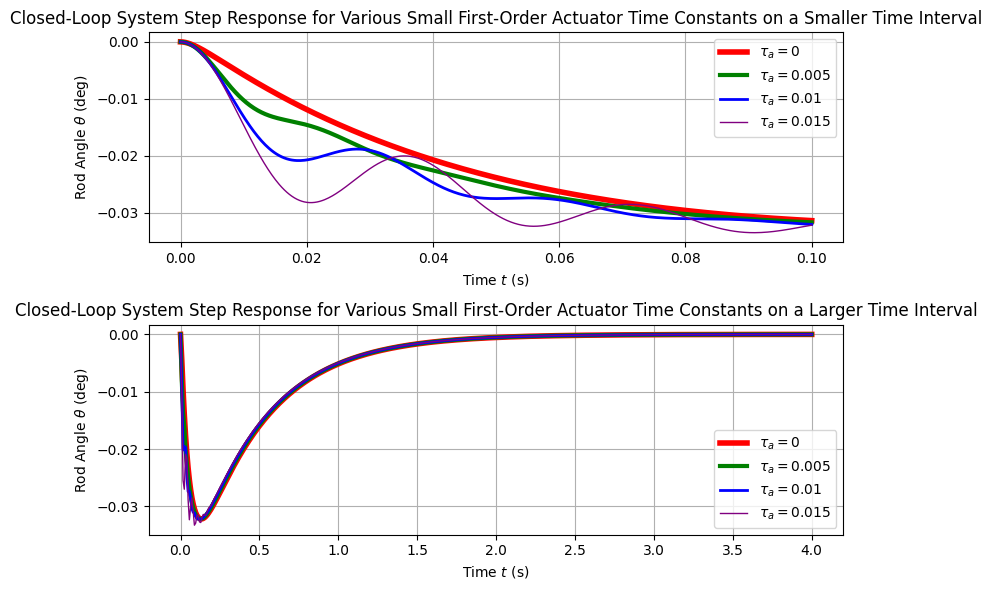

In [77]:
# defining times to find step response at
ts1 = np.linspace(0, 0.1, 500) # small time plot
ts2 = np.linspace(0, 4, 500) # large time plot

# Create a figure and a set of subplots to show small and large time interval
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.set_title('Closed-Loop System Step Response for Various Small First-Order Actuator Time Constants on a Smaller Time Interval')
ax2.set_title('Closed-Loop System Step Response for Various Small First-Order Actuator Time Constants on a Larger Time Interval')

# ACTUATOR 1 - unchanged from prior section since time constant is taken as zero
# redefining Ga
Ka = 1 # fixed
taua = 0 # will be varied
Ga = Ka / (taua * s + 1)
# redefining the closed-loop (Theta over D) system containing the new actuator
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# calculating and plotting step response for small time
t_step, theta_step = ctrl.step_response(Gload, ts1)
ax1.plot(t_step, np.rad2deg(theta_step), 'r', linewidth=4, label=r'$\tau_a=0$')
# calculating and plotting step response for large time
t_step, theta_step = ctrl.step_response(Gload, ts2)
ax2.plot(t_step, np.rad2deg(theta_step), 'r', linewidth=4, label=r'$\tau_a=0$')

# ACTUATOR 2 - introducing very small time constant
# redefining Ga
Ka = 1 # fixed
taua = 0.005 # will be varied
Ga = Ka / (taua * s + 1)
# redefining the closed-loop (Theta over D) system containing the new actuator
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# calculating and plotting step response
t_step, theta_step = ctrl.step_response(Gload, ts1)
ax1.plot(t_step, np.rad2deg(theta_step), 'g', linewidth=3, label=r'$\tau_a=0.005$')
# calculating and plotting step response for large time
t_step, theta_step = ctrl.step_response(Gload, ts2)
ax2.plot(t_step, np.rad2deg(theta_step), 'g', linewidth=3, label=r'$\tau_a=0.005$')

# ACTUATOR 3
# redefining Ga
Ka = 1 # fixed
taua = 0.01 # will be varied
Ga = Ka / (taua * s + 1)
# redefining the closed-loop (Theta over D) system containing the new actuator
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# calculating and plotting step response
t_step, theta_step = ctrl.step_response(Gload, ts1)
ax1.plot(t_step, np.rad2deg(theta_step), 'b', linewidth=2, label=r'$\tau_a=0.01$')
# calculating and plotting step response for large time
t_step, theta_step = ctrl.step_response(Gload, ts2)
ax2.plot(t_step, np.rad2deg(theta_step), 'b', linewidth=2, label=r'$\tau_a=0.01$')

# ACTUATOR 4
# redefining Ga
Ka = 1 # fixed
taua = 0.015 # will be varied
Ga = Ka / (taua * s + 1)
# redefining the closed-loop (Theta over D) system containing the new actuator
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# calculating and plotting step response
t_step, theta_step = ctrl.step_response(Gload, ts1)
ax1.plot(t_step, np.rad2deg(theta_step), 'purple', linewidth=1, label=r'$\tau_a=0.015$')
# calculating and plotting step response for large time
t_step, theta_step = ctrl.step_response(Gload, ts2)
ax2.plot(t_step, np.rad2deg(theta_step), 'purple', linewidth=1, label=r'$\tau_a=0.015$')

# configuring plot
ax1.set_ylabel(r'Rod Angle $\theta$ (deg)')
ax1.set_xlabel(r'Time $t$ (s)')
ax2.set_ylabel(r'Rod Angle $\theta$ (deg)')
ax2.set_xlabel(r'Time $t$ (s)')
ax1.grid()
ax2.grid()
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()

### Closed-loop system response for various large values of $\tau_a$ referenced to $\tau_a=0$

#### Impulse response

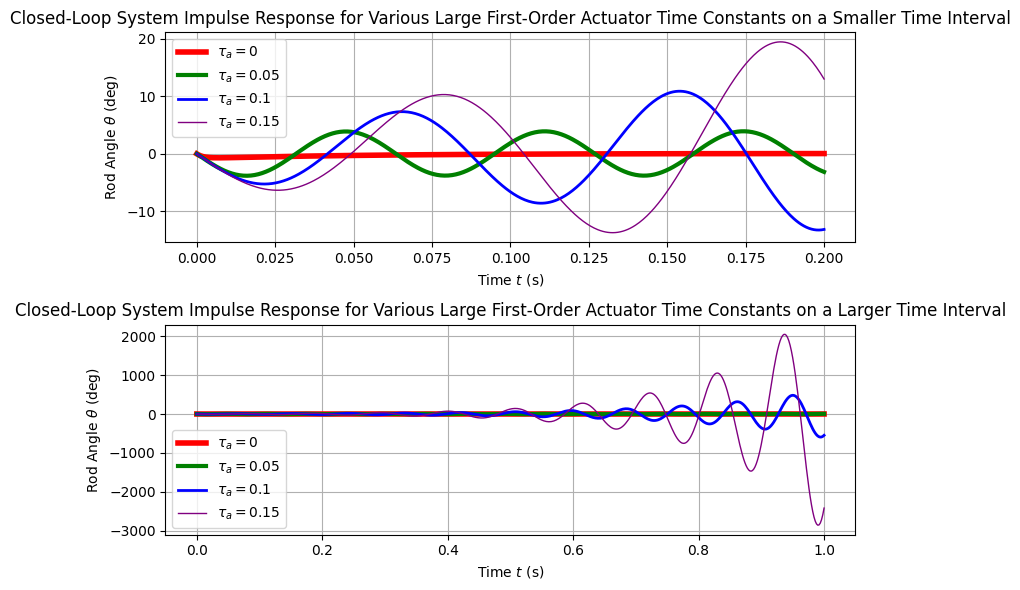

In [78]:
# defining times to find impulse response at
ts1 = np.linspace(0, 0.2, 500) # small time plot
ts2 = np.linspace(0, 1, 500) # large time plot

# Create a figure and a set of subplots to show small and large time interval
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.set_title('Closed-Loop System Impulse Response for Various Large First-Order Actuator Time Constants on a Smaller Time Interval')
ax2.set_title('Closed-Loop System Impulse Response for Various Large First-Order Actuator Time Constants on a Larger Time Interval')

# ACTUATOR 1 - unchanged from prior section since time constant is taken as zero
# redefining Ga
Ka = 1 # fixed
taua = 0 # will be varied
Ga = Ka / (taua * s + 1)
# redefining the closed-loop (Theta over D) system containing the new actuator
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# calculating and plotting impulse response for small time
t_imp, theta_imp = ctrl.impulse_response(Gload, ts1)
ax1.plot(t_imp, np.rad2deg(theta_imp), 'r', linewidth=4, label=r'$\tau_a=0$')
# calculating and plotting impulse response for large time
t_imp, theta_imp = ctrl.impulse_response(Gload, ts2)
ax2.plot(t_imp, np.rad2deg(theta_imp), 'r', linewidth=4, label=r'$\tau_a=0$')

# ACTUATOR 2 - introducing very small time constant
# redefining Ga
Ka = 1 # fixed
taua = 0.05 # will be varied
Ga = Ka / (taua * s + 1)
# redefining the closed-loop (Theta over D) system containing the new actuator
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# calculating and plotting impulse response
t_imp, theta_imp = ctrl.impulse_response(Gload, ts1)
ax1.plot(t_imp, np.rad2deg(theta_imp), 'g', linewidth=3, label=r'$\tau_a=0.05$')
# calculating and plotting impulse response for large time
t_imp, theta_imp = ctrl.impulse_response(Gload, ts2)
ax2.plot(t_imp, np.rad2deg(theta_imp), 'g', linewidth=3, label=r'$\tau_a=0.05$')

# ACTUATOR 3
# redefining Ga
Ka = 1 # fixed
taua = 0.1 # will be varied
Ga = Ka / (taua * s + 1)
# redefining the closed-loop (Theta over D) system containing the new actuator
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# calculating and plotting impulse response
t_imp, theta_imp = ctrl.impulse_response(Gload, ts1)
ax1.plot(t_imp, np.rad2deg(theta_imp), 'b', linewidth=2, label=r'$\tau_a=0.1$')
# calculating and plotting impulse response for large time
t_imp, theta_imp = ctrl.impulse_response(Gload, ts2)
ax2.plot(t_imp, np.rad2deg(theta_imp), 'b', linewidth=2, label=r'$\tau_a=0.1$')

# ACTUATOR 4
# redefining Ga
Ka = 1 # fixed
taua = 0.15 # will be varied
Ga = Ka / (taua * s + 1)
# redefining the closed-loop (Theta over D) system containing the new actuator
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# calculating and plotting impulse response
t_imp, theta_imp = ctrl.impulse_response(Gload, ts1)
ax1.plot(t_imp, np.rad2deg(theta_imp), 'purple', linewidth=1, label=r'$\tau_a=0.15$')
# calculating and plotting impulse response for large time
t_imp, theta_imp = ctrl.impulse_response(Gload, ts2)
ax2.plot(t_imp, np.rad2deg(theta_imp), 'purple', linewidth=1, label=r'$\tau_a=0.15$')

# configuring plot
ax1.set_ylabel(r'Rod Angle $\theta$ (deg)')
ax1.set_xlabel(r'Time $t$ (s)')
ax2.set_ylabel(r'Rod Angle $\theta$ (deg)')
ax2.set_xlabel(r'Time $t$ (s)')
ax1.grid()
ax2.grid()
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()

#### Step response

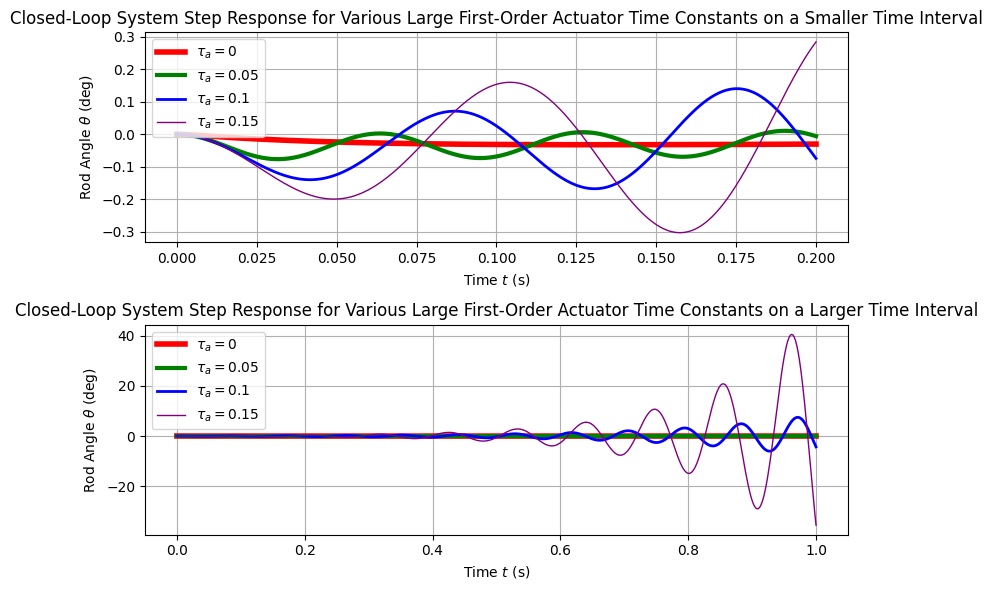

In [79]:
# defining times to find step response at
ts1 = np.linspace(0, 0.2, 500) # small time plot
ts2 = np.linspace(0, 1, 500) # large time plot

# Create a figure and a set of subplots to show small and large time interval
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.set_title('Closed-Loop System Step Response for Various Large First-Order Actuator Time Constants on a Smaller Time Interval')
ax2.set_title('Closed-Loop System Step Response for Various Large First-Order Actuator Time Constants on a Larger Time Interval')

# ACTUATOR 1 - unchanged from prior section since time constant is taken as zero
# redefining Ga
Ka = 1 # fixed
taua = 0 # will be varied
Ga = Ka / (taua * s + 1)
# redefining the closed-loop (Theta over D) system containing the new actuator
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# calculating and plotting step response for small time
t_step, theta_step = ctrl.step_response(Gload, ts1)
ax1.plot(t_step, np.rad2deg(theta_step), 'r', linewidth=4, label=r'$\tau_a=0$')
# calculating and plotting step response for large time
t_step, theta_step = ctrl.step_response(Gload, ts2)
ax2.plot(t_step, np.rad2deg(theta_step), 'r', linewidth=4, label=r'$\tau_a=0$')

# ACTUATOR 2 - introducing very small time constant
# redefining Ga
Ka = 1 # fixed
taua = 0.05 # will be varied
Ga = Ka / (taua * s + 1)
# redefining the closed-loop (Theta over D) system containing the new actuator
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# calculating and plotting step response
t_step, theta_step = ctrl.step_response(Gload, ts1)
ax1.plot(t_step, np.rad2deg(theta_step), 'g', linewidth=3, label=r'$\tau_a=0.05$')
# calculating and plotting step response for large time
t_step, theta_step = ctrl.step_response(Gload, ts2)
ax2.plot(t_step, np.rad2deg(theta_step), 'g', linewidth=3, label=r'$\tau_a=0.05$')

# ACTUATOR 3
# redefining Ga
Ka = 1 # fixed
taua = 0.1 # will be varied
Ga = Ka / (taua * s + 1)
# redefining the closed-loop (Theta over D) system containing the new actuator
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# calculating and plotting step response
t_step, theta_step = ctrl.step_response(Gload, ts1)
ax1.plot(t_step, np.rad2deg(theta_step), 'b', linewidth=2, label=r'$\tau_a=0.1$')
# calculating and plotting step response for large time
t_step, theta_step = ctrl.step_response(Gload, ts2)
ax2.plot(t_step, np.rad2deg(theta_step), 'b', linewidth=2, label=r'$\tau_a=0.1$')

# ACTUATOR 4
# redefining Ga
Ka = 1 # fixed
taua = 0.15 # will be varied
Ga = Ka / (taua * s + 1)
# redefining the closed-loop (Theta over D) system containing the new actuator
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# calculating and plotting step response
t_step, theta_step = ctrl.step_response(Gload, ts1)
ax1.plot(t_step, np.rad2deg(theta_step), 'purple', linewidth=1, label=r'$\tau_a=0.15$')
# calculating and plotting step response for large time
t_step, theta_step = ctrl.step_response(Gload, ts2)
ax2.plot(t_step, np.rad2deg(theta_step), 'purple', linewidth=1, label=r'$\tau_a=0.15$')

# configuring plot
ax1.set_ylabel(r'Rod Angle $\theta$ (deg)')
ax1.set_xlabel(r'Time $t$ (s)')
ax2.set_ylabel(r'Rod Angle $\theta$ (deg)')
ax2.set_xlabel(r'Time $t$ (s)')
ax1.grid()
ax2.grid()
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()

### Brief discussion of results

A smaller actuator time constant results in less oscillatory behaviour of the closed-loop system, therefore the smaller the time constant, the more desirable the response of the closed-loop system; as $\tau_a$ increases the oscillatory behaviour of the system also increases. As $\tau_a$ is increased from zero, the closed-loop system remains stable to a unit impulse and step disturbance, converging to the set point of zero in a reasonable settling time provided $\tau_a < 0.05$. For $\tau_a > 0.05$, the oscillations diverge exponentially; the system is no longer stable for a unit impulse or step disturbance. Therefore, for this closed-loop system to be effective, an actuator time constant (preferably significantly) less than $\tau_a=0.05$ is required.

## 3. Studying effect of sensor delay on closed-loop system

For this section, we assume the actuator has the transfer function

$$G_a = \frac{1}{0.03s+1},$$

and the sensor causes a time delay $t_d$ and therefore has transfer function

$$G_s=e^{-t_{d}s}.$$

Since the `control` library cannot operate on exponentials, we apply a Padé approximation to $G_s$.

Again, since the unit impulse and step most closely resemble typical disturbances which this system is likely to practically experience, we will plot how varying the sensor time delay $t_d$ affects the impulse and step response of the closed-loop system.

### Closed-loop system response for various values of $t_d$

#### Impulse response

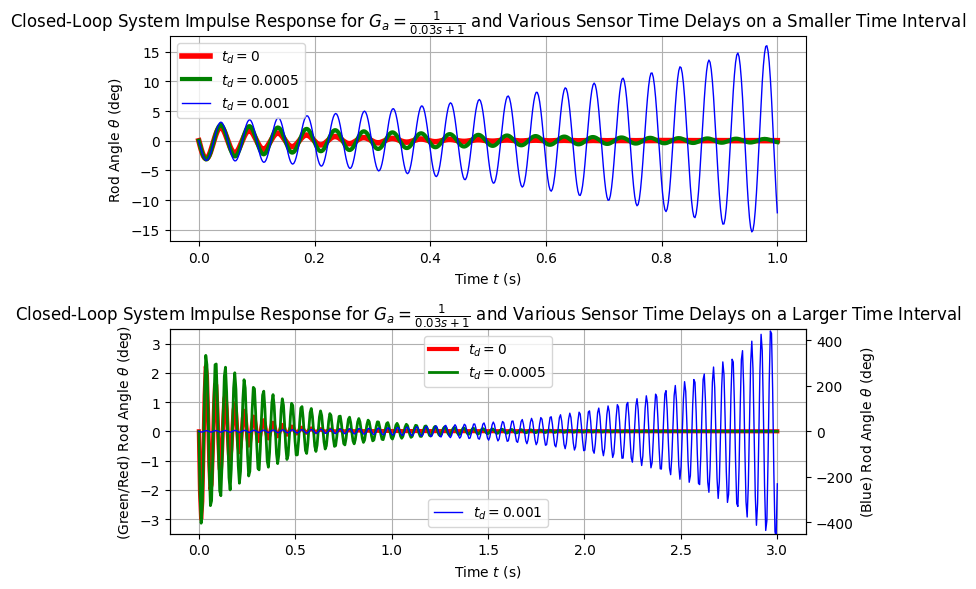

In [80]:
# defining times to find impulse response at
ts1 = np.linspace(0, 1, 500) # small time plot
ts2 = np.linspace(0, 3, 500) # large time plot
# Create a figure and a set of subplots to show small and large time interval
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.set_title(r'Closed-Loop System Impulse Response for $G_a=\frac{1}{0.03s+1}$ and Various Sensor Time Delays on a Smaller Time Interval')
ax2.set_title(r'Closed-Loop System Impulse Response for $G_a=\frac{1}{0.03s+1}$ and Various Sensor Time Delays on a Larger Time Interval')
# redefining actuator transfer function
Ga = 1 / (0.03 * s + 1)

# SENSOR 1 - td = 0 which means sensor transfer function is still unity
# defining delay introduced by sensor
td = 0
# redefining sensor transfer function
num, den = ctrl.pade(td, 3) # third order Padé approximation for a reasonably accurate rational approximation of the exponential
Gs = ctrl.TransferFunction(num, den)
# redefining closed-loop system containing the new sensor
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# calculating and plotting impulse response for small time
t_imp, theta_imp = ctrl.impulse_response(Gload, ts1)
ax1.plot(t_imp, np.rad2deg(theta_imp), 'r', linewidth=4, label=r'$t_d=0$')
# calculating and plotting impulse response for large time
t_imp, theta_imp = ctrl.impulse_response(Gload, ts2)
ax2.plot(t_imp, np.rad2deg(theta_imp), 'r', linewidth=3, label=r'$t_d=0$')

# SENSOR 2
# defining delay introduced by sensor
td = 0.0005
# redefining sensor transfer function
num, den = ctrl.pade(td, 3) # third order Padé approximation for a reasonably accurate rational approximation of the exponential
Gs = ctrl.TransferFunction(num, den)
# redefining closed-loop system containing the new sensor
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# calculating and plotting impulse response for small time
t_imp, theta_imp = ctrl.impulse_response(Gload, ts1)
ax1.plot(t_imp, np.rad2deg(theta_imp), 'g', linewidth=3, label=r'$t_d=0.0005$')
# calculating and plotting impulse response for large time
t_imp, theta_imp = ctrl.impulse_response(Gload, ts2)
ax2.plot(t_imp, np.rad2deg(theta_imp), 'g', linewidth=2, label=r'$t_d=0.0005$')

# SENSOR 3
# defining delay introduced by sensor
td = 0.001
# redefining sensor transfer function
num, den = ctrl.pade(td, 3) # third order Padé approximation for a reasonably accurate rational approximation of the exponential
Gs = ctrl.TransferFunction(num, den)
# redefining closed-loop system containing the new sensor
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# calculating and plotting impulse response for small time
t_imp, theta_imp = ctrl.impulse_response(Gload, ts1)
ax1.plot(t_imp, np.rad2deg(theta_imp), 'b', linewidth=1, label=r'$t_d=0.001$')
# calculating and plotting impulse response for large time
t_imp, theta_imp = ctrl.impulse_response(Gload, ts2)
ax3 = ax2.twinx()
ax3.plot(t_imp, np.rad2deg(theta_imp), 'b', linewidth=1, label=r'$t_d=0.001$')

# configuring plot
ax1.set_ylabel(r'Rod Angle $\theta$ (deg)')
ax1.set_xlabel(r'Time $t$ (s)')
ax2.set_ylabel(r'(Green/Red) Rod Angle $\theta$ (deg)')
ax2.set_ylim(-3.5, 3.5)
ax3.set_ylabel(r'(Blue) Rod Angle $\theta$ (deg)')
ax3.set_ylim(-450, 450)
ax2.set_xlabel(r'Time $t$ (s)')
ax1.grid()
ax2.grid()
ax1.legend()
ax2.legend(loc='upper center')
ax3.legend(loc='lower center')
plt.tight_layout()
plt.show()

#### Step response

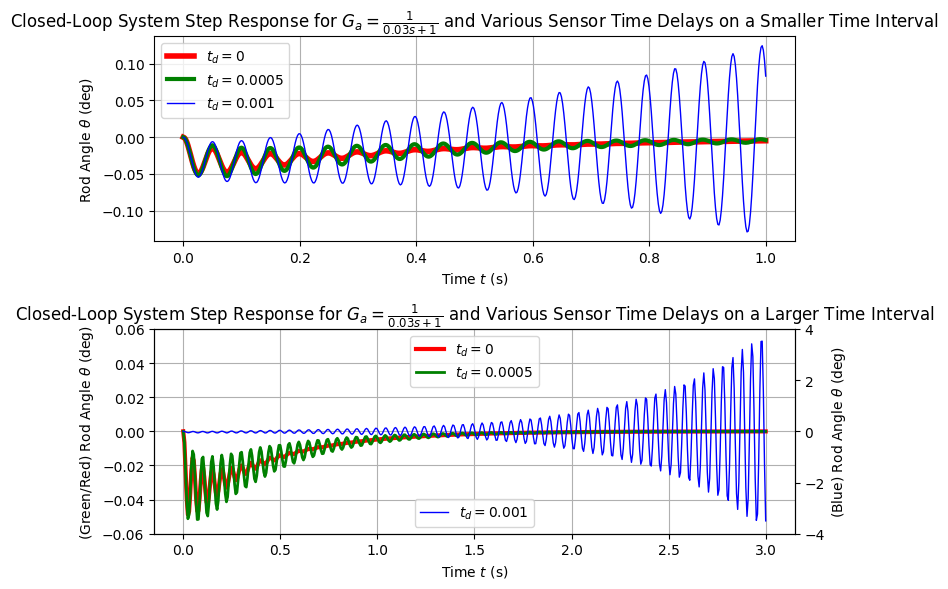

In [81]:
# defining times to find step response at
ts1 = np.linspace(0, 1, 500) # small time plot
ts2 = np.linspace(0, 3, 500) # large time plot
# Create a figure and a set of subplots to show small and large time interval
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.set_title(r'Closed-Loop System Step Response for $G_a=\frac{1}{0.03s+1}$ and Various Sensor Time Delays on a Smaller Time Interval')
ax2.set_title(r'Closed-Loop System Step Response for $G_a=\frac{1}{0.03s+1}$ and Various Sensor Time Delays on a Larger Time Interval')
# redefining actuator transfer function
Ga = 1 / (0.03 * s + 1)

# SENSOR 1 - td = 0 which means sensor transfer function is still unity
# defining delay introduced by sensor
td = 0
# redefining sensor transfer function
num, den = ctrl.pade(td, 3) # third order Padé approximation for a reasonably accurate rational approximation of the exponential
Gs = ctrl.TransferFunction(num, den)
# redefining closed-loop system containing the new sensor
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# calculating and plotting step response for small time
t_step, theta_step = ctrl.step_response(Gload, ts1)
ax1.plot(t_step, np.rad2deg(theta_step), 'r', linewidth=4, label=r'$t_d=0$')
# calculating and plotting step response for large time
t_step, theta_step = ctrl.step_response(Gload, ts2)
ax2.plot(t_step, np.rad2deg(theta_step), 'r', linewidth=3, label=r'$t_d=0$')

# SENSOR 2
# defining delay introduced by sensor
td = 0.0005
# redefining sensor transfer function
num, den = ctrl.pade(td, 3) # third order Padé approximation for a reasonably accurate rational approximation of the exponential
Gs = ctrl.TransferFunction(num, den)
# redefining closed-loop system containing the new sensor
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# calculating and plotting step response for small time
t_step, theta_step = ctrl.step_response(Gload, ts1)
ax1.plot(t_step, np.rad2deg(theta_step), 'g', linewidth=3, label=r'$t_d=0.0005$')
# calculating and plotting step response for large time
t_step, theta_step = ctrl.step_response(Gload, ts2)
ax2.plot(t_step, np.rad2deg(theta_step), 'g', linewidth=2, label=r'$t_d=0.0005$')

# SENSOR 3
# defining delay introduced by sensor
td = 0.001
# redefining sensor transfer function
num, den = ctrl.pade(td, 3) # third order Padé approximation for a reasonably accurate rational approximation of the exponential
Gs = ctrl.TransferFunction(num, den)
# redefining closed-loop system containing the new sensor
Gload = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# calculating and plotting step response for small time
t_step, theta_step = ctrl.step_response(Gload, ts1)
ax1.plot(t_step, np.rad2deg(theta_step), 'b', linewidth=1, label=r'$t_d=0.001$')
# calculating and plotting step response for large time
t_step, theta_step = ctrl.step_response(Gload, ts2)
ax3 = ax2.twinx()
ax3.plot(t_step, np.rad2deg(theta_step), 'b', linewidth=1, label=r'$t_d=0.001$')

# configuring plot
ax1.set_ylabel(r'Rod Angle $\theta$ (deg)')
ax1.set_xlabel(r'Time $t$ (s)')
ax2.set_ylabel(r'(Green/Red) Rod Angle $\theta$ (deg)')
ax2.set_ylim(-0.06, 0.06)
ax3.set_ylabel(r'(Blue) Rod Angle $\theta$ (deg)')
ax3.set_ylim(-4, 4)
ax2.set_xlabel(r'Time $t$ (s)')
ax1.grid()
ax2.grid()
ax1.legend()
ax2.legend(loc='upper center')
ax3.legend(loc='lower center')
plt.tight_layout()
plt.show()

### Brief discussion of results

When $t_d=0$, the impulse and step response of the closed-loop system is already overly oscillatory due to the actuator being modelled as a first order system with a time constant of $30$ ms (studied in more detail in Section 2). As the sensor time delay $t_d$ increases, the magnitude of the oscillations and the settling time of the system both increase. If the sensor time delay is less than $0.5$ ms the closed-loop system remains stable for a unit impulse or step disturbance, converging to the set point of zero. For sensor time delays greater than approximately $0.5$ ms, the closed-loop system loses its stability to a unit impulse or step disturbance, causing the response to consist of oscillations which grow exponentially over time. Therefore, for the closed-loop system to operate correctly, the time delay of the sensor must be less than $0.5$ ms.

## 4. Designing a closed-loop control system to stabilise both $\theta$ and $x$

The block diagram below shows how $X(s)$ relates to the closed-loop system which controls the rod angle $\theta$.

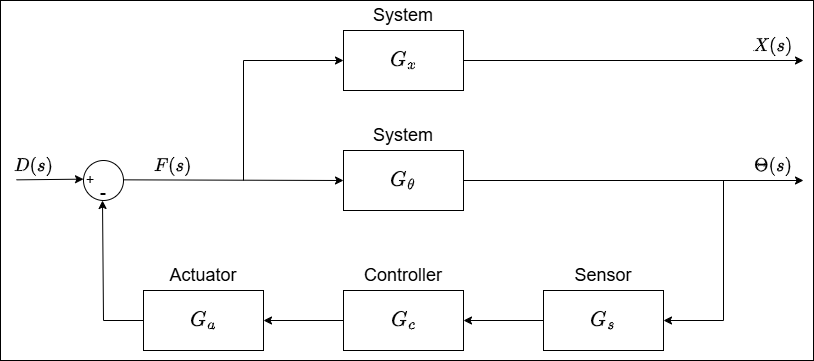

We will define two transfer functions

$$G_{\text{load}\theta}=\frac{\Theta}{D} \quad \text{ and } \quad G_{\text{load}x}=\frac{X}{D}.$$

From the block diagram,

$$G_{\text{load}x}=\frac{G_{\text{load}\theta}G_x}{G_\theta}.$$

Since we are analysing how $x$ behaves when the control system proposed in Section 1 is implemented, here we make the same assumption as in Section 1; that $G_a=G_s=1$.

In [82]:
# redefining Ga and Gs
Ga, Gs = 1, 1

From the section 'Finding transfer functions', we know that

$$G_x=\frac{X(s)}{F(s)}=\frac{e(s^2-d)+cf}{s^2(s^2-d)},$$

where

$$e = \frac{4}{4M+m}, \quad f = \frac{3gm}{4M+m}.$$

In [83]:
# defining e and f (d is defined in Section 1)
e = 4 / (4 * M + m)
f = 3 * g * m / (4 * M + m)
# defining Gx
Gx = (e * (s**2 - d) + c * f) / (s**2 * (s**2 - d))
# printing Gx
Gx

TransferFunction(array([  3.07692308,   0.        , -64.68131868]), array([  1.        ,   0.        , -25.87252747,   0.        ,
         0.        ]))

### Studying how $x(t)$ behaves for the control system proposed in Section 1

In [84]:
# Defining PID parameters
Kp = -1500
taui = 2
taud = 0.05
# defining PID controller transfer function
Gc = Kp * (1 + taui/s + taud*s)
# defining the transfer function from D to theta, Gloadtheta
Gloadtheta = ctrl.feedback(Gtheta, (Gs*Gc*Ga))
# calculating Gloadx from the previously given equation
Gloadx = Gloadtheta * Gx / Gtheta
# checking poles of Gloadx to see if it is BIBO stable
poles = ctrl.poles(Gloadx)
# printing the poles
print(f"Closed-loop system poles: ")
for p in poles:
    print(f"{p.real:.2f} {'+ ' if p.imag >= 0 else '- '}{abs(p.imag):.2f}j")

Closed-loop system poles: 
-473.77 + 0.00j
-18.47 + 0.00j
5.09 + 0.00j
-5.09 + 0.00j
-2.26 + 0.00j
0.00 + 0.00j
0.00 + 0.00j


We have one pole with a positive real part and 2 poles at the origin, therefore the closed-loop system is not BIBO stable.

Plotting the response of the horizontal position $x$ to standard disturbances (unit impulse and step) when the closed-loop system proposed in Section 1 is used

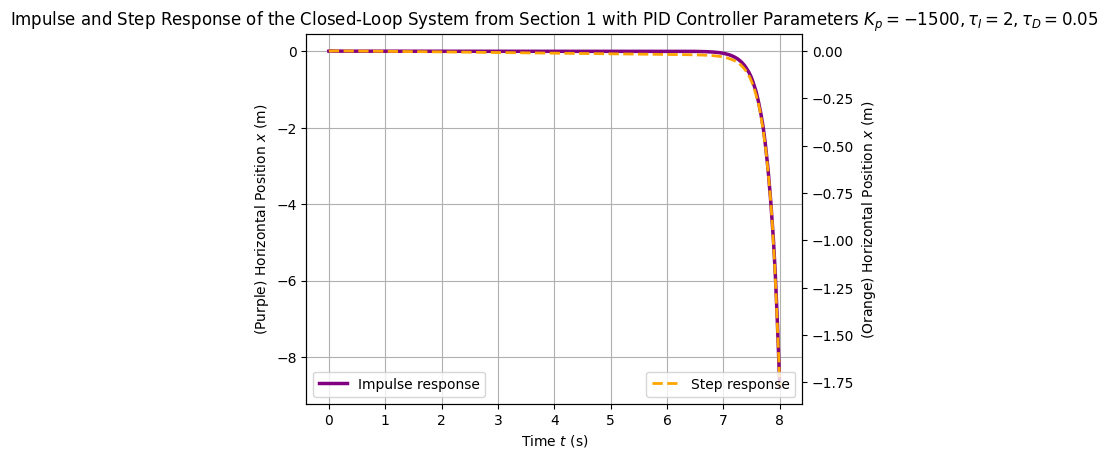

In [85]:
# defining twin axes to allow better visualisation due to extreme scaling difference between step and impulse response
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# defining times to evaluate response at
ts = np.linspace(0, 8, 500)
# calculating the system response when disturbance is unit impulse
t_imp, x_imp = ctrl.impulse_response(Gloadx, ts)
# calculating the step response
t_step, x_step = ctrl.step_response(Gloadx, ts)
# plotting the impulse response
ax1.plot(t_imp, x_imp, 'purple', linewidth=2.5, label='Impulse response')
# plotting the step response
ax2.plot(t_step, x_step, 'orange', linestyle='--', linewidth=2, label='Step response')

# configuring plot
ax1.set_xlabel(r'Time $t$ (s)')
ax1.set_ylabel(r'(Purple) Horizontal Position $x$ (m)')
ax2.set_ylabel(r'(Orange) Horizontal Position $x$ (m)')
plt.title(r'Impulse and Step Response of the Closed-Loop System from Section 1 with PID Controller Parameters $K_p=-1500, \tau_I=2, \tau_D=0.05$')
ax1.grid()
ax1.legend(loc='lower left')
ax2.legend(loc='lower right')
plt.show()

The horizontal position increases unbounded when the disturbance input into the closed-loop system proposed in Section 1 is a unit impulse or unit step. The proposed system is not BIBO stable for $x$, so a new closed-loop system must be designed to stabilise both $\theta$ and $x$.

### Designing a control system to stabilise both $\theta$ and $x$

The block diagram below shows a revised closed-loop system which allows feedback from both $x$ and $\theta$ at the same time. For simplicity, the actuator and sensor blocks are ommitted since $G_a=G_s=1$.

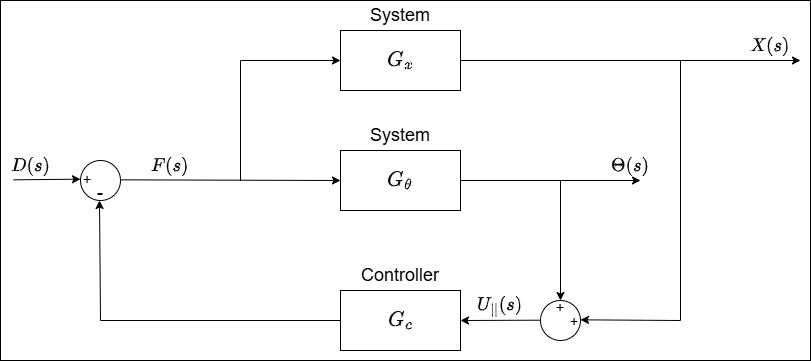

Since $G_x$ and $G_{\theta}$ are connected in parallel, the overall transfer function for this parallel section is given by

$$G_{||}=\frac{U_{||}}{F}=G_x+G_\theta,$$

allowing the block diagram to be simplified to the following.

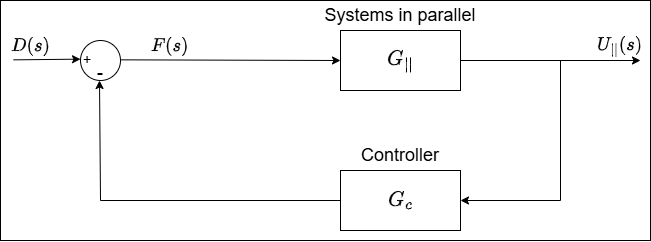

We will define another transfer function,

$$G_{\text{load}||}=\frac{U_{||}}{D}.$$

Since we know that $U_{||}(s)=X(s)+\Theta(s)$, by applying the inverse Laplace transform we also know that $u_{||}(t)=x(t)+\theta(t)$. Therefore if $G_{\text{load}||}$ exhibits BIBO stability with $u_{||}(t)$ converging to the set point of zero, then both $x(t)$ and $\theta(t)$ will also converge to the set point of zero, essentially meaning the control system has stabilised both $x$ and $\theta$.

In [86]:
# defining Gll
Gll = Gx + Gtheta
# Defining PID paramters
Kp = -2000
taui = 2
taud = 0.007
# defining PID controller transfer function
Gc = Kp * (1 + taui/s + taud*s)
# defining transfer function from D to Ull, Gloadll
Gloadll = ctrl.feedback(Gll, Gc)

# evaluating the poles of the closed loop system
poles = ctrl.poles(Gloadll)
# printing the poles
print(f"Closed-loop system poles: ")
for p in poles:
    print(f"{p.real:.2f} {'+ ' if p.imag >= 0 else '- '}{abs(p.imag):.2f}j")

Closed-loop system poles: 
-23.60 + 79.60j
-23.60 - 79.60j
5.09 + 0.00j
-0.01 + 4.30j
-0.01 - 4.30j
-5.09 + 0.00j
-2.03 + 0.00j


There is a pole at $s=5.09$ which is fixed and will not move regardless of how the PID controller is tuned. This inverted pendulum system cannot be stabilised for both $x$ and $\theta$.

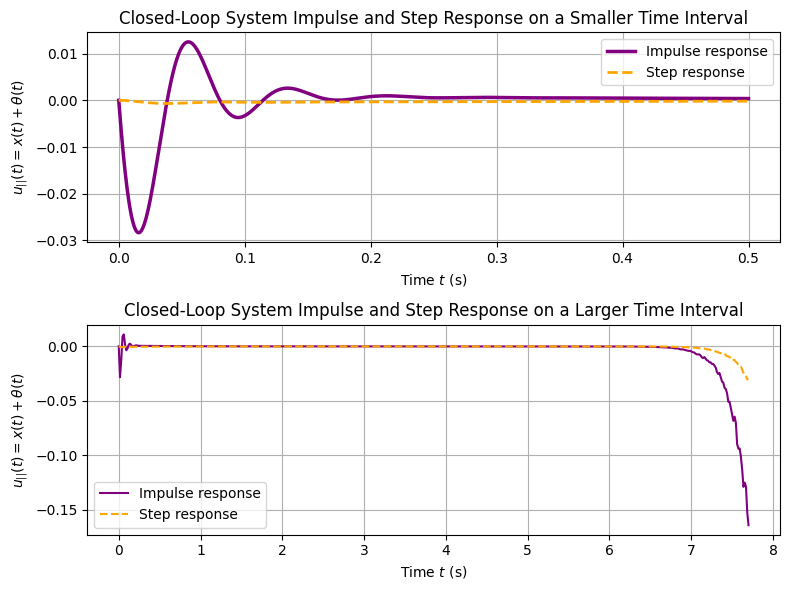

In [87]:
# defining times to find impulse response at
ts1 = np.linspace(0, 0.5, 1000) # small time plot
ts2 = np.linspace(0, 7.7, 500) # large time plot
# Create a figure and a set of subplots to show small and large time interval
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.set_title(r'Closed-Loop System Impulse and Step Response on a Smaller Time Interval')
ax2.set_title(r'Closed-Loop System Impulse and Step Response on a Larger Time Interval')

# calculating the system response when disturbance is unit impulse
t_imp, x_imp = ctrl.impulse_response(Gloadll, ts1)
# calculating the step response
t_step, x_step = ctrl.step_response(Gloadll, ts1)
# plotting the impulse response
ax1.plot(t_imp, x_imp, 'purple', linewidth=2.5, label='Impulse response')
# plotting the step response
ax1.plot(t_step, x_step, 'orange', linestyle='--', linewidth=2, label='Step response')

# calculating the system response when disturbance is unit impulse
t_imp, x_imp = ctrl.impulse_response(Gloadll, ts2)
# calculating the step response
t_step, x_step = ctrl.step_response(Gloadll, ts2)
# plotting the impulse response
ax2.plot(t_imp, x_imp, 'purple', linewidth=1.5, label='Impulse response')
# plotting the step response
ax2.plot(t_step, x_step, 'orange', linestyle='--', linewidth=1.5, label='Step response')

# configuring plot
ax1.grid()
ax2.grid()
ax1.legend()
ax2.legend()
ax1.set_ylabel(r'$u_{||}(t)=x(t)+\theta(t)$')
ax2.set_ylabel(r'$u_{||}(t)=x(t)+\theta(t)$')
ax1.set_xlabel(r'Time $t$ (s)')
ax2.set_xlabel(r'Time $t$ (s)')
plt.tight_layout()
plt.show()

### Brief discussion of results

The horizontal position of the cart $x$ grows unbounded when the controller proposed in Section 1 is used. By introducing an additional feedback loop from $x$ and retuning the PID controller we can create a control system which has the desired response ($u_{||}=x+\theta=0$) for roughly six seconds, however it does not successfully stabilise both $x$ and $\theta$ at the set point of zero as shown by the unbounded growth after roughly 7 seconds. Due to a fixed pole at $s=5.09$, this closed-loop system cannot be BIBO stable regardless of how the PID controller is tuned. To achieve stability of both $x$ and $\theta$, a more complex controller may be required.

## 5. (Bonus) PID controller for the orginal nonlinear system

In this section, we assume the actuator is a first order system with parameters $K_a=1$ and $\tau_a=0.03$,

$$G_a=\frac{1}{0.03s+1},$$

and the sensor has transfer function

$$G_s=1.$$





The dynamical system can be expressed in SSR as

$$\dot{x}_1=x_2$$
$$\dot{x}_2=\phi(F, x_3, x_4)=\frac{4mlx_4^2\sin{(x_3)}+4F-3mg\sin{(x_3)}\cos{(x_3)}}{4(M+m)-3m\cos^{2}{(x_3)}}$$
$$\dot{x}_3=x_4$$
$$\dot{x}_4=\psi(F, x_3, x_4)=\frac{- 3 F \cos{\left(x_{3} \right)} - 3 \ell m x_{4}^{2} \sin{\left(x_{3} \right)} \cos{\left(x_{3} \right)} + 3 g \left(M + m\right) \sin{\left(x_{3} \right)}}{\ell \left(4 M - 3 m \cos^{2}{\left(x_{3} \right)} + 4 m\right)}.$$

Since we were unable to stabilise $x$ and $\theta$ together in Section 4, we will simulate the impulse and step response of the closed-loop system proposed in Section 1, which will still stabilise the system for $\theta$ as the actuator time constant is less than the lowest value causing instability found in Section 2, as well as the plots from Section 3 showing stability while having the same actuator transfer function. Therefore, we expect $\theta$ to converge to the set point of zero and $x$ to grow unbounded. As we are simulating the response of the nonlinear system, the approach will be to use Python to solve the system of differential equations describing the dynamical system for a given input force, then plot the relevant states, $x_1(t) \text{ and } x_3(t)$.

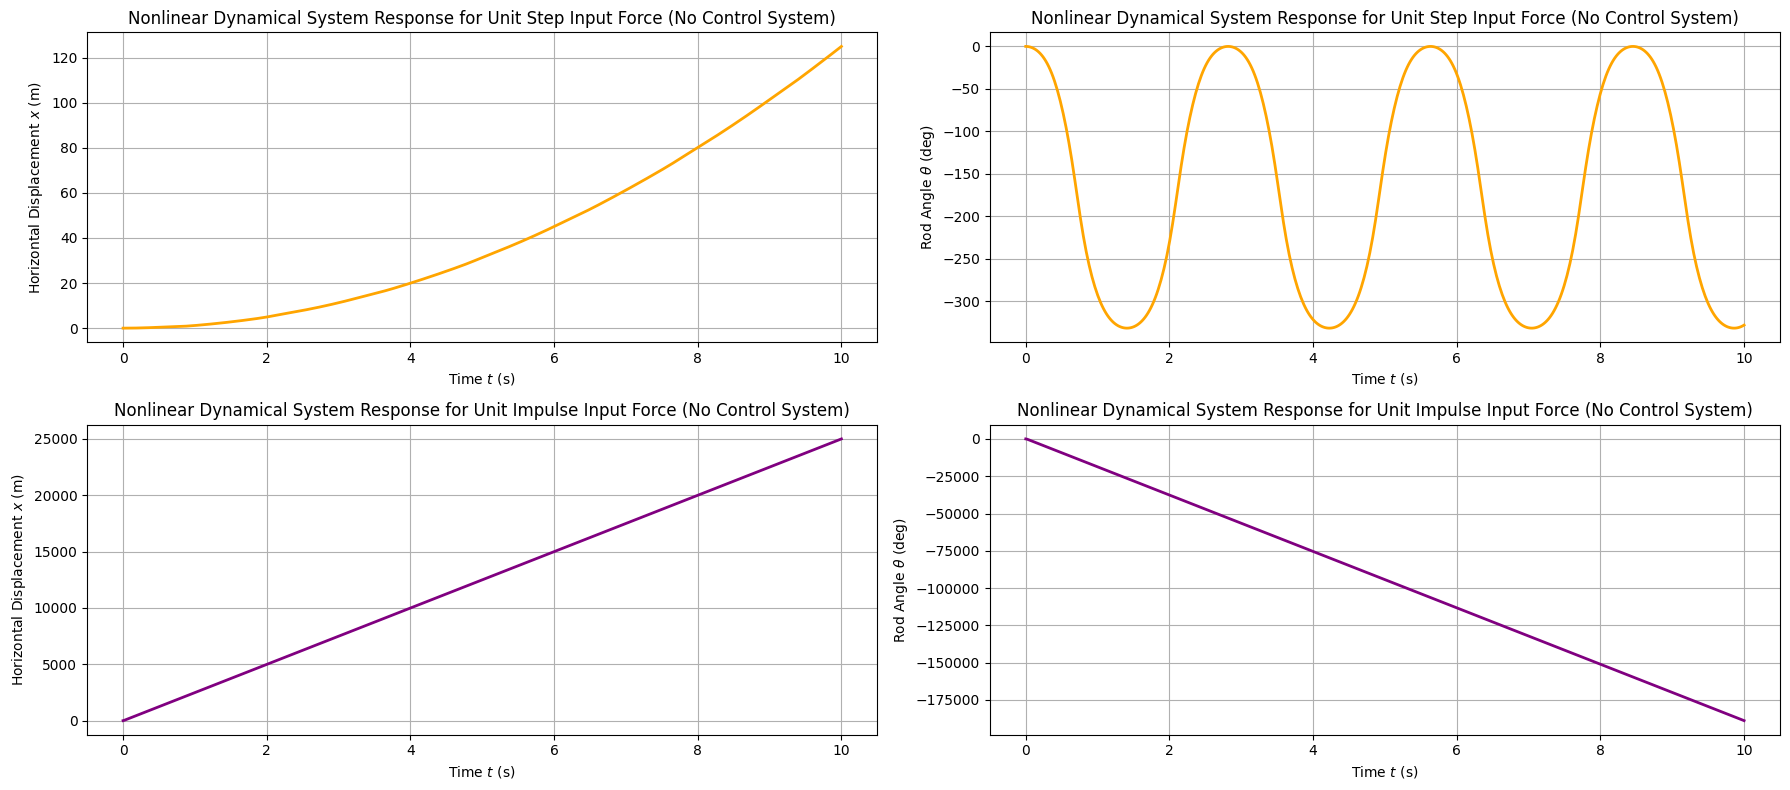

In [88]:
# importing required function
import scipy.integrate as spi

# defining time points to evaluate solution at
timePoints = np.linspace(0, 10, 500)

# defining PID parameters
Kp = -1500
taui = 2
taud = 0.05

# redefining transfer functions to match the question
Gc = Kp * (1 + taui/s + taud * s)
Ga = 1/(0.03*s+1)
Gs = 1

# defining the system of ordinary differential equations describing the inverted pendulum dynamics
def stepRightSideODE(x, t, F): # for unit step force input
    F = force_step(t)
    x1 = x[0]
    x2 = x[1]
    x3 = x[2]
    x4 = x[3]
    dxdt = [x2,(4*m*ell*x4**2*np.sin(x3)+4*F-3*m*g*np.sin(x3)*np.cos(x3))/(4*(M+m)-3*m*np.cos(x3)**2), x4, (-3*F*np.cos(x3)-3*ell*m*x4**2*np.sin(x3)*np.cos(x3)+3*g*(M+m)*np.sin(x3))/(ell*(4*M-3*m*np.cos(x3)**2+4*m))]
    return dxdt

def impRightSideODE(x, t, F): # for unit impulse force input
    F = force_imp(t)
    x1 = x[0]
    x2 = x[1]
    x3 = x[2]
    x4 = x[3]
    dxdt = [x2,(4*m*ell*x4**2*np.sin(x3)+4*F-3*m*g*np.sin(x3)*np.cos(x3))/(4*(M+m)-3*m*np.cos(x3)**2), x4, (-3*F*np.cos(x3)-3*ell*m*x4**2*np.sin(x3)*np.cos(x3)+3*g*(M+m)*np.sin(x3))/(ell*(4*M-3*m*np.cos(x3)**2+4*m))]
    return dxdt

# assuming zero intial conditions
x0 = [0, 0, 0, 0]

# make F input whatever has been found from the previous part of this section
def force_step(t):
    return 1.0 if t >= 0 else 0.0  # Step input
def force_imp(t):
    return 100000 if (t >= 0 and t<0.01) else 0.0  # Simulate unit impulse

# solving the system of ODEs to get rod angle and horizontal displacement for unit step input
solutionODE = spi.odeint(stepRightSideODE, x0, timePoints, args=(force_step,))

# Create a figure and a set of subplots to show small and large time interval
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(18, 8))
ax1.set_title(r'Nonlinear Dynamical System Response for Unit Step Input Force (No Control System)')
ax3.set_title(r'Nonlinear Dynamical System Response for Unit Impulse Input Force (No Control System)')
ax2.set_title(r'Nonlinear Dynamical System Response for Unit Step Input Force (No Control System)')
ax4.set_title(r'Nonlinear Dynamical System Response for Unit Impulse Input Force (No Control System)')

# plotting x1 (horizontal displacement) and x3 (rod angle)
ax1.plot(timePoints, solutionODE[:, 0], label='Step response', linewidth='2', color='orange')
ax2.plot(timePoints, np.rad2deg(solutionODE[:, 2]), label='Step response', linewidth='2', color='orange')

# resolving the system of ODEs to get rod angle and horizontal displacement for unit impulse input
solutionODE = spi.odeint(impRightSideODE, x0, timePoints, args=(force_step,))

# plotting x1 (horizontal displacement) and x3 (rod angle)
ax3.plot(timePoints, solutionODE[:, 0], label='Impulse response', linewidth='2', color='purple')
ax4.plot(timePoints, np.rad2deg(solutionODE[:, 2]), label='Impulse response', linewidth='2', color='purple')


# configuring plots
ax1.set_xlabel(r'Time $t$ (s)')
ax2.set_xlabel(r'Time $t$ (s)')
ax3.set_xlabel(r'Time $t$ (s)')
ax4.set_xlabel(r'Time $t$ (s)')
ax1.set_ylabel(r'Horizontal Displacement $x$ (m)')
ax2.set_ylabel(r'Rod Angle $\theta$ (deg)')
ax3.set_ylabel(r'Horizontal Displacement $x$ (m)')
ax4.set_ylabel(r'Rod Angle $\theta$ (deg)')
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
plt.tight_layout()
plt.show()

### Brief discussion of results

These plots simulate the original, uncontrolled nonlinear dynamical system when the force input to the system is a unit step or unit impulse, meaning the fact that the responses are unstable is consistent with the linear uncontrolled model shown in the section 'Finding transfer functions'. To proceed to simulating the controlled system, we need to find the system input force $F(t)$ when the disturbance is a unit impulse or step. With reference to the simplified block diagram given in Section 1, this may be calculated by the following method:

$$F(s)=D(s)-\Theta(s)G_c(s)G_a(s) \quad \therefore \quad \mathscr{L}(F(s))=\mathscr{L}(D(s)-\Theta(s)G_c(s)G_a(s)) \\ =\mathscr{L}(D(s))-\mathscr{L}(\Theta(s)G_c(s)G_a(s))=d(t)-(\theta(t)*g_{c}(t)*g_{a}(t)).$$

This can be summarised as the equation

$$F(t)=d(t)-(\theta(t)*g_{c}(t)*g_{a}(t)).$$

I was unable to implement the function for F(t) in Python, although if I did complete this step the next stage would be to define functions for $d(t)$ as a unit impulse and step, then evaluate $F(t)$ so that the same code as above can be used to simulate the controlled system by simply simulating how the system responds for this calculated $F(t)$, which is controlled by the closed-loop system.